In [3]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from glob import glob
import os
import psutil
from cdo import Cdo   # python version
cdo = Cdo()
%matplotlib inline


In [ ]:
# create ymonmean data file with CDO
# cdo ymonmean -cat siconc_SImon_NorESM2-MM_historical_r1i1p1f1_gn_198001-198912.nc siconc_SImon_NorESM2-MM_historical_r1i1p1f1_gn_199001-199912.nc ./siconc_NorESM_historical_ymm.nc\

## regrid ocean data to r360*180 grid

In [13]:
cdo.remapbil('r360x180', input='/mnt/tacco-ns1004k-cmroot/NorESM2-MM/ssp585/v20191108/siconc_SImon_NorESM2-MM_ssp585_r1i1p1f1_gn_204101-205012.nc', output='~/siconc_SImon_NorESM2-MM_ssp585_r1i1p1f1_gn_204101-205012_r360x180.nc')
cdo.remapbil('r360x180', input='/mnt/tacco-ns1004k-cmroot/NorESM2-MM/historical/v20191108/siconc_SImon_NorESM2-MM_historical_r1i1p1f1_gn_198001-198912.nc',
             output='~/siconc_SImon_NorESM2-MM_historical_r1i1p1f1_gn_198001-198912_r360x180.nc')
cdo.remapbil('r360x180', input='~/siconc_NorESM_historical_ymm.nc',output='~/siconc_NorESM_historical_ymm_r360x180.nc')

'~/siconc_SImon_NorESM2-MM_historical_r1i1p1f1_gn_198001-200912_r360x180.nc'

## read in the regridded data

In [7]:
files_ssp='~/siconc_SImon_NorESM2-MM_ssp585_r1i1p1f1_gn_204101-205012_r360x180.nc'
sic_ssp = xr.open_dataset(files_ssp).sel(time=slice('2050-01-01','2050-12-31'))
sic_hist = xr.open_dataset('~/siconc_SImon_NorESM2-MM_historical_r1i1p1f1_gn_198001-198912_r360x180.nc')
sic_hist_ymm = xr.open_dataset('~/siconc_NorESM_historical_ymm_r360x180.nc')

In [14]:
sic_hist_ymm

<xarray.Dataset>
Dimensions:  (time: 12, lat: 180, lon: 361)
Coordinates:
  * time     (time) object 1999-01-16 12:00:00 ... 1999-12-16 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Data variables:
    siconc   (time, lat, lon) float32 nan nan nan nan ... 99.95 99.95 99.95

In [8]:
#plot sea ice edge (use 15% threshold) of 2050 and 1981-2010 average on top of above figures
from cartopy.util import add_cyclic_point
def add_cyclic_point_to_dataset(ds):
    # Load data
    data = ds["siconc"]

    # Generate data with cyclic point and generate longitude with cyclic point
    cyclic_data, cyclic_longitude = add_cyclic_point(data.values, coord=data['lon'])

    # Create new coords that will be used in creation of new dataset
    # Replicate coords of existing dataset and replace longitude with cyclic longitude
    coords = {dim: data.coords[dim] for dim in data.dims}
    coords["lon"] = cyclic_longitude

    new_ds = xr.Dataset(
        data_vars={
            "siconc": xr.DataArray(cyclic_data, dims=data.dims, coords=coords)
        })
    return new_ds 
    
sic_ssp= add_cyclic_point_to_dataset(sic_ssp)
sic_hist = add_cyclic_point_to_dataset(sic_hist)
sic_hist_ymm = add_cyclic_point_to_dataset(sic_hist_ymm)

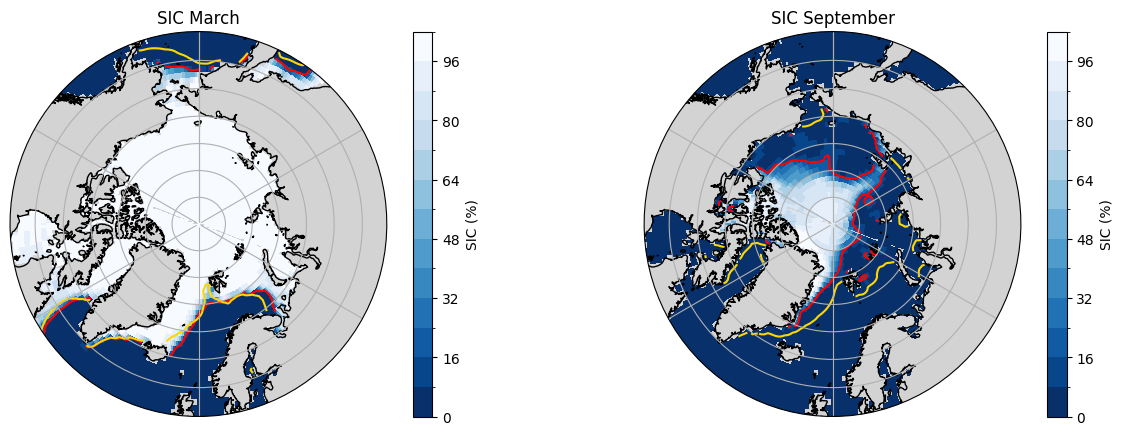

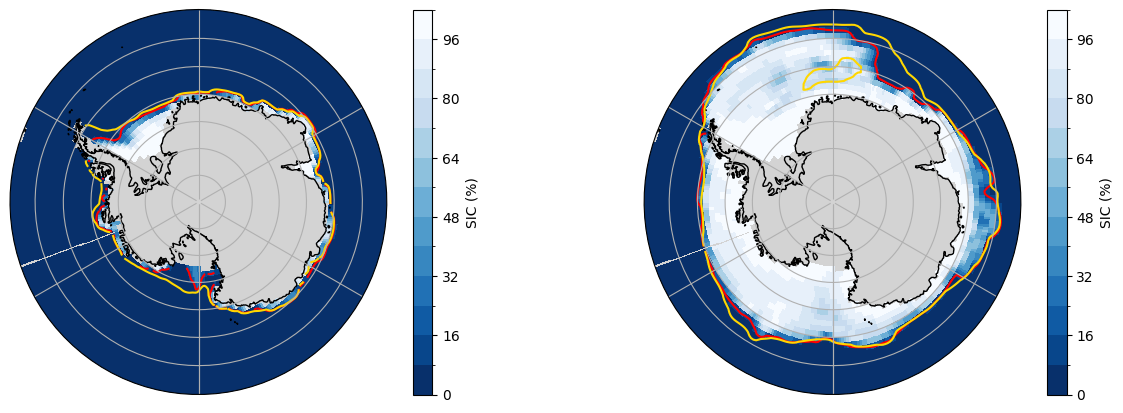

In [19]:
import matplotlib.path as mpath
fig, axs = plt.subplots(ncols=2, figsize=(15,5), subplot_kw={'projection': ccrs.NorthPolarStereo()})
sic_ssp.sel(time=slice('2050-03-01','2050-03-31')).mean(dim='time').siconc.plot(ax = axs[0],cmap='Blues_r',levels=15,transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'SIC (%)'})
sic_ssp.sel(time=slice('2050-09-01','2050-09-30')).mean(dim='time').siconc.plot(ax = axs[1],cmap='Blues_r',levels=15,transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'SIC (%)'})

axs[1].contour(sic_ssp.lon, sic_ssp.lat, sic_ssp.siconc.sel(time=slice('2050-09-01','2050-09-30')).mean(dim='time'),
               levels=np.array([15]),transform=ccrs.PlateCarree(), colors='red')
axs[0].contour(sic_ssp.lon, sic_ssp.lat, sic_ssp.siconc.sel(time=slice('2050-03-01','2050-03-31')).mean(dim='time'),
               levels=np.array([15]),transform=ccrs.PlateCarree(), colors='red')

axs[1].contour(sic_hist.lon, sic_hist.lat, sic_hist_ymm.siconc.sel(time=slice('1999-09-01','1999-09-30')).mean(dim='time'),
               levels=np.array([15]),transform=ccrs.PlateCarree(), colors='gold')
axs[0].contour(sic_hist.lon, sic_hist.lat, sic_hist_ymm.siconc.sel(time=slice('1999-03-01','1999-03-31')).mean(dim='time'),
               levels=np.array([15]),transform=ccrs.PlateCarree(), colors='gold')
'''
axs[0].contour(sic_hist.lon, sic_hist.lat, sic_hist.siconc.sel(time=slice('1980-03-01','1980-03-31')).mean(dim='time'),
               levels=np.array([15]),transform=ccrs.PlateCarree(), colors='aqua')
axs[1].contour(sic_hist.lon, sic_hist.lat, sic_hist.siconc.sel(time=slice('1980-09-01','1980-09-30')).mean(dim='time'),
               levels=np.array([15]),transform=ccrs.PlateCarree(), colors='aqua')
'''
#axs[0].set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
axs[1].set_title('SIC September')
axs[0].set_title('SIC March')
axs[0].set_facecolor('lightgrey')
axs[1].set_facecolor('lightgrey')

axs[0].coastlines()
axs[1].coastlines()

    # Limit the map to -60 degrees latitude and below.
axs[0].set_extent([-180, 180, 90, 55], ccrs.PlateCarree())
axs[1].set_extent([-180, 180, 90, 55], ccrs.PlateCarree())

axs[0].gridlines()
axs[1].gridlines()

    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

axs[0].set_boundary(circle, transform=axs[0].transAxes)
axs[1].set_boundary(circle, transform=axs[1].transAxes)
fig.savefig('cvb_Sea_ice_NH.png',bbox_inches='tight')

fig, axs = plt.subplots(ncols=2, figsize=(15,5), subplot_kw={'projection': ccrs.SouthPolarStereo()})
sic_ssp.sel(time=slice('2050-03-01','2050-03-31')).mean(dim='time').siconc.plot(ax = axs[0],cmap='Blues_r',levels=15,transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'SIC (%)'})
sic_ssp.sel(time=slice('2050-09-01','2050-09-30')).mean(dim='time').siconc.plot(ax = axs[1],cmap='Blues_r',levels=15,transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'SIC (%)'})
axs[0].coastlines()
axs[1].coastlines()
axs[0].set_facecolor('lightgrey')
axs[1].set_facecolor('lightgrey')
axs[1].contour(sic_ssp.lon, sic_ssp.lat, sic_ssp.siconc.sel(time=slice('2050-09-01','2050-09-30')).mean(dim='time'),
               levels=np.array([15]),transform=ccrs.PlateCarree(), colors='red')
axs[0].contour(sic_ssp.lon, sic_ssp.lat, sic_ssp.siconc.sel(time=slice('2050-03-01','2050-03-31')).mean(dim='time'),
               levels=np.array([15]),transform=ccrs.PlateCarree(), colors='red')
'''
axs[1].contour(sic_hist.lon, sic_hist.lat, sic_hist.siconc.sel(time=slice('1980-09-01','1980-09-30')).mean(dim='time'),
               levels=np.array([15]),transform=ccrs.PlateCarree(), colors='aqua')
axs[0].contour(sic_hist.lon, sic_hist.lat, sic_hist.siconc.sel(time=slice('1980-03-01','1980-03-31')).mean(dim='time'),
               levels=np.array([15]),transform=ccrs.PlateCarree(), colors='aqua')'''

axs[1].contour(sic_hist.lon, sic_hist.lat, sic_hist_ymm.siconc.sel(time=slice('1999-09-01','1999-09-30')).mean(dim='time'),
               levels=np.array([15]),transform=ccrs.PlateCarree(), colors='gold')
axs[0].contour(sic_hist.lon, sic_hist.lat, sic_hist_ymm.siconc.sel(time=slice('1999-03-01','1999-03-31')).mean(dim='time'),
               levels=np.array([15]),transform=ccrs.PlateCarree(), colors='gold')


    # Limit the map to -60 degrees latitude and below.
axs[0].set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
axs[1].set_extent([-180, 180, -90, -55], ccrs.PlateCarree())

axs[0].gridlines()
axs[1].gridlines()

    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

axs[0].set_boundary(circle, transform=axs[0].transAxes)
axs[1].set_boundary(circle, transform=axs[1].transAxes)

fig.savefig('cvb_Sea_ice_SH.png',bbox_inches='tight')

Blue: Sea ice edge in 1980 \
Red: Sea ice edge in 2050 \
Yellow: average historical 1980